# Laboratorium 4. - sygnały wielowymiarowe w obliczeniach Monte Carlo
W ramach zajęć zajęto się analizą wybranych problemów modelowania, w których występują
sekwencje/sygnały wielowymiarowe. Dokonano generacji wielowymiarowego sygnału pseudolosowego o zadanym rozkładzie. Następnie dokonano zamodelowania jego przepustowości w zależności od parametrów sygnalizacji świetlnej.


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from scipy import signal
import matplotlib.pyplot as plt
from scipy import signal
import scipy

Do generacji sygnałów skorzystano z generatora liczb z rozkładu normalnego napisanego na poprzednich zajęciach. Następnie zgodnie z transformacją Boxa-Mullera na podstawie dwóch niezależnych liczb o rozkładzie jednostajnym z przedziału zero jeden, wygenerowano dwie niezależne liczby z rozkładu normalnego N(0,1). W celu zmiany wartości oczekiwanej dodano do wszystkich wartości daną liczbę.

In [24]:
def own_uniform(number, seed, tringle_number=5):
    results = np.zeros(number)
    for i in range(number):
        seed = ((signal.sawtooth(2 * np.pi * tringle_number * seed))+1)/2
        results[i] = seed
    return results

In [25]:
times_number = 1000
A = np.sqrt(-2*np.log(own_uniform(times_number, 0.152323, 45)))*np.cos(2*np.pi*own_uniform(times_number, 0.3434, 45)) + 3
B = np.sqrt(-2*np.log(own_uniform(times_number, 0.152323, 45)))*np.sin(2*np.pi*own_uniform(times_number, 0.3434, 45)) + 6
C = np.sqrt(-2*np.log(own_uniform(times_number, 0.16453, 45)))*np.cos(2*np.pi*own_uniform(times_number, 0.765, 45)) + 4
D = np.sqrt(-2*np.log(own_uniform(times_number, 0.16453, 45)))*np.sin(2*np.pi*own_uniform(times_number, 0.765, 45)) +5 

Następnie sprowadzono wartości do dodatnich liczb całkowitych oraz sprawdzono czy macierz korelacji ma po przekątnych wartości bliskie 1, co jest zgodne z oczekiwaniami (odchylenie standardowe równe 1). Ponadto pozostałe powinny być bliskie 0, co określa brak zależności pomiędzy liczbami uzyskanymi transformacją Boxa-Mullera.

In [26]:
all_road = np.array([A, B, C, D])
all_road[all_road<0]=0
all_road = all_road.astype(int)

In [27]:
covaraince = np.cov(all_road)
cov_matrix = np.round(covaraince, 2)
cov_matrix

array([[ 1.01, -0.01,  0.02,  0.03],
       [-0.01,  1.05, -0.02,  0.07],
       [ 0.02, -0.02,  1.  ,  0.04],
       [ 0.03,  0.07,  0.04,  1.07]])

Kolejnym punktem było, aby za pomocą rozkładu Cholesky'ego wyindukować zadaną zależności liniową między wcześniej wygenerowanymi niezależnymi zmiennymi z rozkładu normalnego. W tym celu należy wyznaczyć wartość X z podanej poniżej wartości sigma $XX^T = \sum$.

In [28]:
sigma=np.array([[1, 0.5, 0, 0], [0.5, 1, 0.5, 0], [0, 0.5, 1, 0.5], [0, 0, 0.5, 1]])
sigma

array([[1. , 0.5, 0. , 0. ],
       [0.5, 1. , 0.5, 0. ],
       [0. , 0.5, 1. , 0.5],
       [0. , 0. , 0.5, 1. ]])

Macierz X uzyskano za pomocą funkcji $cholesky$ z pakiety $scipy.linalg$. Następnie przemnożono macierzy $X$ razy niezależne sygnały all_road. Uzyskana macież kowariancji jest zbliżona do oczekiwanej.

In [29]:
X = scipy.linalg.cholesky(sigma)
result_road = X @ all_road
np.round(np.cov(result_road), 2)

array([[1.26, 0.45, 0.05, 0.05],
       [0.45, 1.11, 0.51, 0.06],
       [0.05, 0.51, 1.1 , 0.54],
       [0.05, 0.06, 0.54, 0.67]])

In [74]:
result_road = result_road.astype(int)

Następnie wygenerowano całkowitą liczbę pojazdów na drodze, zakładając zerową przepustowość skrzyżowania. Ilość pojazdów na danej drodze rośnie zgodnie z zadaną wartością oczekiwaną.

In [34]:
sum_cars = np.zeros((4, times_number)).astype(int)
for i in range(4):
    for j in range(times_number):
        sum_cars[i,j] = sum(result_road[i, :j+1])

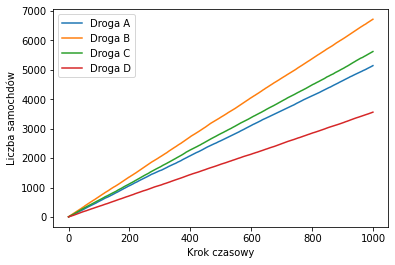

In [41]:
plt.plot(np.arange(times_number), sum_cars[0], label='Droga A')
plt.plot(np.arange(times_number), sum_cars[1], label='Droga B')
plt.plot(np.arange(times_number), sum_cars[2], label='Droga C')
plt.plot(np.arange(times_number), sum_cars[3], label='Droga D')
plt.xlabel('Krok czasowy')
plt.ylabel('Liczba samochdów')
plt.legend()

## Zadanie 2 - ptymalizacja cyklu swietlnego – analiza Monte Carlo) 
W oparciu o symulator skonstruowany w zadaniu 1. rozpatrzono problem optymalnego ustawienia sygnalizacji drogowej. Zamiast wartości całkowitego czasu przejazdu pojedynczego pojazdu wprowadzono $Tj$ czyli ilość pojazdów jaka może przejechać przez przepustową drogę w jednostce czasu. Ustalono, że $Tj=13$, aby wartość była wyższa od połowy sumy wartości oczekiwanych wszystkich dróg, która wynosi 9.
 

In [140]:
def simulate(roads, AC=1, BD=1, Tj=12):
    result_road = roads.copy()
    AC_list = list(range(1, AC+1))
    can_go_AC = np.zeros(times_number)
    can_go_BD = np.zeros(times_number)
    for i in range(times_number):
        if i%(AC+BD) in AC_list:
            can_go_AC[i] = Tj
        else:
            can_go_BD[i] = Tj
    sum_cars = np.zeros((4, times_number)).astype(int)
    for i in range(4):
        for j in range(1, times_number):
            if i%2 == 0:
                result_road[i,j] = max(result_road[i,j-1]+result_road[i,j]-can_go_AC[j],0)
            else:
                result_road[i,j] = max(result_road[i,j-1]+result_road[i,j]-can_go_BD[j],0)
    
    return result_road

Przetestowano rezultaty w których jednostek czasu przypadających na połączenie drogi B i D jest więcej lub równo tyle co dla A i C, ze względu na wyższe sumy wartości oczekiwanych dla połączeń. W symulacji nie uwzględniono czasu na światło pomarańczowe, dlatego najkorzystniejsze są rozwiązania, w których następują częste zmiany przełączeń ruchu. Na podstawie tych spostrzeżeń wybrano testowane rozwiązania.

In [147]:
param_to_test = [[1,1], [1,2], [1,3], [2,3], [3,4], [1,5], [3,5], [4,5], [5,6], [6,7]]
for param in param_to_test:
    print(f'Dla stosunku AC:BD {param[0]}:{param[1]} uzyskano średnią: {np.mean(simulate(result_road, AC=param[0], BD=param[1]))}')
    print(f'Dla stosunku AC:BD {param[0]}:{param[1]} uzyskano maksymalną wartość: {np.max(simulate(result_road, AC=param[0], BD=param[1]))}\n')  

Dla stosunku AC:BD 1:1 uzyskano średnią: 35.10625
Dla stosunku AC:BD 1:1 uzyskano maksymalną wartość: 233

Dla stosunku AC:BD 1:2 uzyskano średnią: 255.7275
Dla stosunku AC:BD 1:2 uzyskano maksymalną wartość: 1106

Dla stosunku AC:BD 1:3 uzyskano średnią: 505.02375
Dla stosunku AC:BD 1:3 uzyskano maksymalną wartość: 2102

Dla stosunku AC:BD 2:3 uzyskano średnią: 60.2525
Dla stosunku AC:BD 2:3 uzyskano maksymalną wartość: 312

Dla stosunku AC:BD 3:4 uzyskano średnią: 9.905
Dla stosunku AC:BD 3:4 uzyskano maksymalną wartość: 49

Dla stosunku AC:BD 1:5 uzyskano średnią: 754.3075
Dla stosunku AC:BD 1:5 uzyskano maksymalną wartość: 3098

Dla stosunku AC:BD 3:5 uzyskano średnią: 136.05925
Dla stosunku AC:BD 3:5 uzyskano maksymalną wartość: 616

Dla stosunku AC:BD 4:5 uzyskano średnią: 10.40025
Dla stosunku AC:BD 4:5 uzyskano maksymalną wartość: 44

Dla stosunku AC:BD 5:6 uzyskano średnią: 12.32775
Dla stosunku AC:BD 5:6 uzyskano maksymalną wartość: 45

Dla stosunku AC:BD 6:7 uzyskano średnią

Zadanie jest przykładem optymalizacji wielokryterialnej, w której optymalizowane są:
- średnia liczba samochodów oczekujących na przejazd przez skrzyżowanie,
- maksymalna liczba samochodów oczekujących na przejazd przez skrzyżowanie.

Żadne z rozwiązań nie dominuje pozostałych. Kryterium średniej najlepiej realizuje stosunek AC:BD 3:4, natomiast wartości maksymalnej stosunek AC:BD 4:5. W celu wyłonienie optymalnego rozwiązania przeprowadzono wizualizacje rozwiązań.


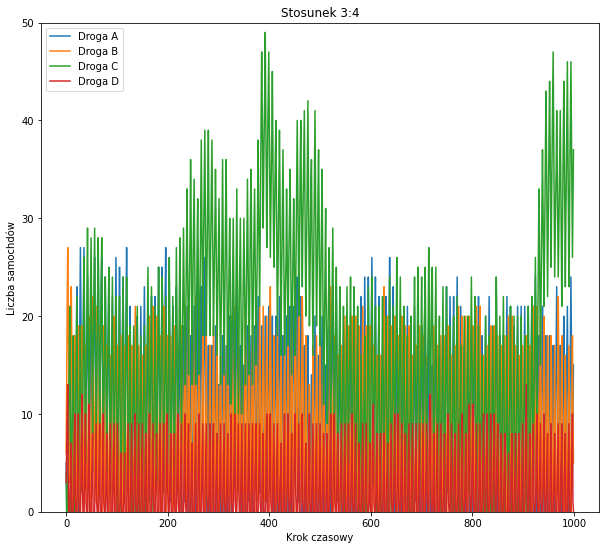

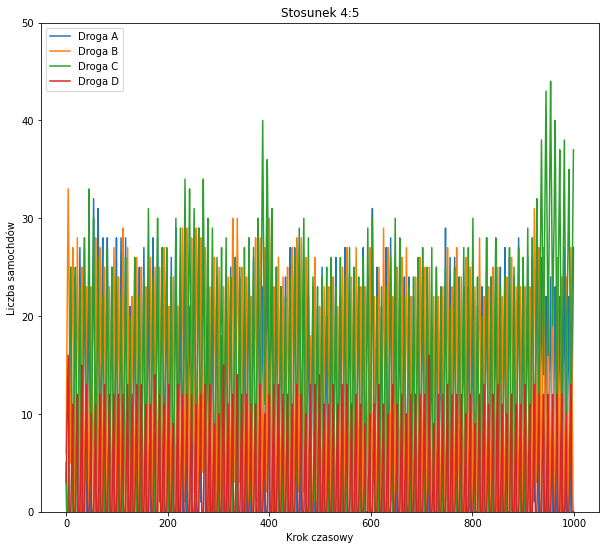

In [163]:
for param in [[3, 4], [4, 5]]:
    res = simulate(result_road, AC=param[0], BD=param[1])
    plt.figure(figsize=(10, 9))
    plt.plot(np.arange(times_number), res[0], label='Droga A')
    plt.plot(np.arange(times_number), res[1], label='Droga B')
    plt.plot(np.arange(times_number), res[2], label='Droga C')
    plt.plot(np.arange(times_number), res[3], label='Droga D')
    plt.ylim([0, 50])
    plt.xlabel('Krok czasowy')
    plt.ylabel('Liczba samochdów')
    plt.legend()
    plt.title(f'Stosunek {param[0]}:{param[1]}')
    plt.show()

Wizualna ocena jest jedną z metod rozwiązywania zadań wielokryterialnych. Po analizie przebiegów wybrano rozwiązanie AC:BD 4:5, ponieważ zawiera mniej wartości odstających. Zbyt długi korek mógłby w ruchu ulicznym blokowac również sąsiednie skrzyżowanie.

Przeprowadzono dodatkową analizę tych samych przebiegów bez przed dodaniem zależności pomiędzy zmiennymi za pomocą Choleskyego.

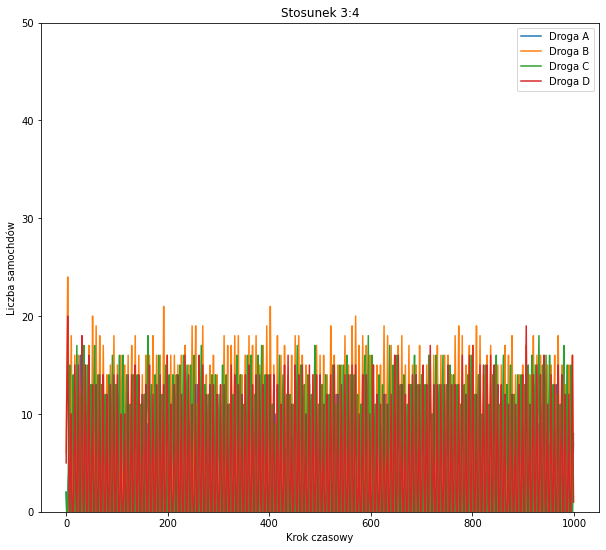

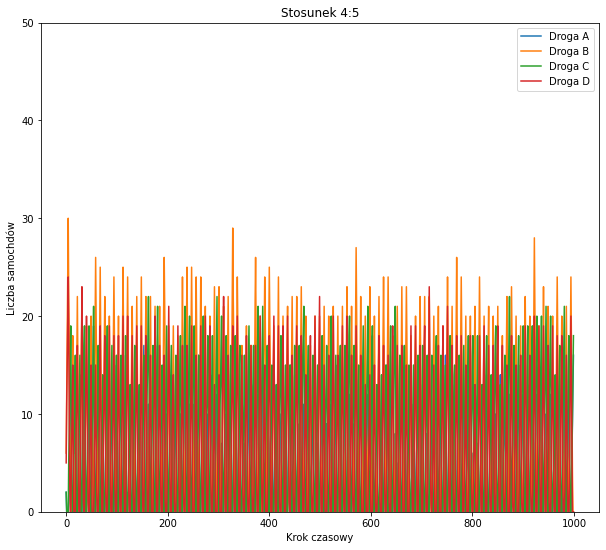

In [164]:
for param in [[3, 4], [4, 5]]:
    res = simulate(all_road, AC=param[0], BD=param[1])
    plt.figure(figsize=(10, 9))
    plt.plot(np.arange(times_number), res[0], label='Droga A')
    plt.plot(np.arange(times_number), res[1], label='Droga B')
    plt.plot(np.arange(times_number), res[2], label='Droga C')
    plt.plot(np.arange(times_number), res[3], label='Droga D')
    plt.ylim([0, 50])
    plt.xlabel('Krok czasowy')
    plt.ylabel('Liczba samochdów')
    plt.legend()
    plt.title(f'Stosunek {param[0]}:{param[1]}')
    plt.show()

Uzyskano bardziej optymalne rezultaty dla niezależnych zmiennych. Jest to zgodne z intuicją, ponieważ jeśli nie ma zależności pomiędzy drogami, łatwiej zachować na nim płynność, w porównaniu do sytuacji gdy wraz z nasileniem pojazdów na jednej drodze, rośnie ich liczba na drodze do niej prostopadłej.

# Laboratorium 5. - Modele VAR

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Zadanie 1
Pierwszym podpunktem było stworzenie modelu var. W rozważanym przykładzie jest on zależny od dwóch wcześniejszych składników składowych. Sam sygnał jest czterowymiarowy. Poprzednie składowe sygnału pochodzą z zależności:

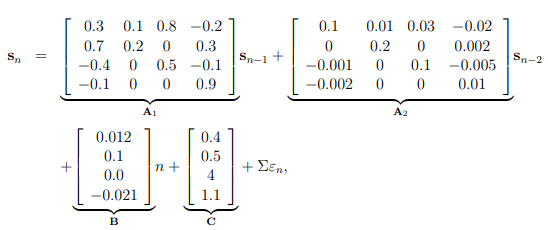

In [2]:
A1 = np.array([[.3, .1, .8, -.2],
              [.7, .2, 0, .3],
              [-.4, 0, .5, -.1],
              [-.1, 0, 0, .9]])

A2 = np.array([[0.1, 0.01, 0.03, -0.02],
              [0, 0.2, 0, 0.002],
              [-0.001, 0, 0.1, -0.005],
              [-0.002, 0, 0, 0.01]])

B = np.array([.012, .1, 0, -.021])

C = np.array([.4, .5, 4, 1.1])

sigma = np.array([[1,0,0,0],
                  [0,1,0,0],
                 [0,0,1,0],
                  [0,0,0,1]])

Zbadano różne wartości wariancji. Z obserwacji wynika, że im mniejsza wartość wariancji tym bardziej wygładzony jest sygnał. W przypadku wariancji równej 100 uzyskano proces, który patrząc po samym przebiegu można nazwać stochastycznym. 

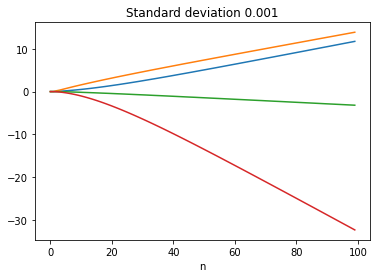

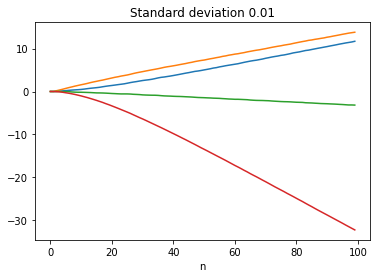

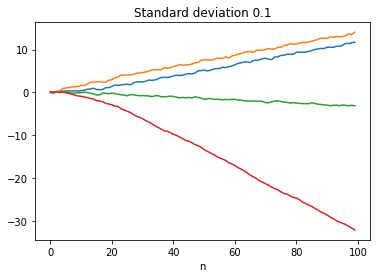

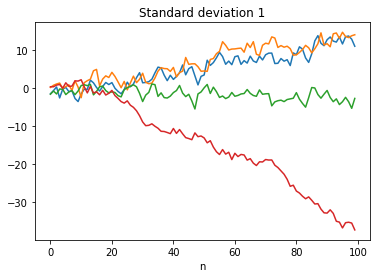

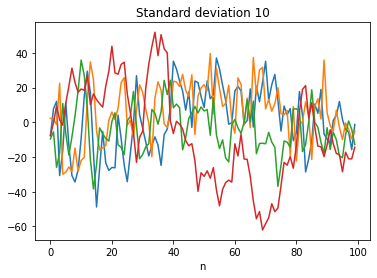

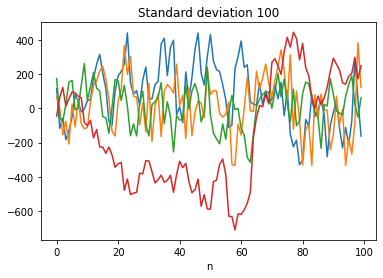

In [3]:
n = 100

all_st_dev = [0.001, 0.01, 0.1, 1, 10, 100]
for st_dev in all_st_dev:
    S = np.zeros((n, 4))
    S[:2] = np.random.normal(0, st_dev, (2, 4))  # mean and standard deviation
    for i in range(2, len(S)):
        S[i] = A1@S[i-1] + A2@S[i-2] + B*i + sigma@np.random.normal(0, st_dev, 4)

    for signal in S.T:
        plt.title(f'Standard deviation {st_dev}')
        plt.xlabel('n')
        plt.plot(np.arange(n), signal)
    plt.show()

## Zadanie 2
W oparciu o sekwencje uzyskane w zadaniu pierwszym skonstruowano model VAR o rzędzie q=2.

In [4]:
import statsmodels.tsa.vector_ar.var_model as vr

st_dev = 1
n = 100
q=2
S = np.zeros((n*2, 4))
S[:2] = np.random.normal(0, st_dev, (2, 4))  # mean and standard deviation
for i in range(2, len(S)):
    S[i] = A1@S[i-1] + A2@S[i-2] + B*i + sigma@np.random.normal(0.01, st_dev, 4)
    
VAR_model = vr.VAR(S[:n])
model_fitted = VAR_model.fit(q)

Podsumowanie modelu:

In [11]:
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 13, Dec, 2021
Time:                     20:06:31
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    26.0294
Nobs:                     85.0000    HQIC:                   21.8379
Log likelihood:          -1046.69    FPE:                7.98801e+08
AIC:                      19.0176    Det(Omega_mle):     9.17705e+07
--------------------------------------------------------------------
Results for equation y1
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -6.916286         5.311856           -1.302           0.193
L1.y1          0.031400         0.189461            0.166           0.868
L1.y2          0.030497         0.201112            0.152           0.879
L1.y3          0.

Jakośc dopasowania modelu do danych S oceniono analizując wartości kryteriów
informacyjnych AIC (ang. Akaike Information Criterion), BIC (ang. Bayesian Information
Criterion), FPE (ang. Final Prediction Error), lub HQIC (Hannan-Quinn BIC).

In [6]:
print(f'AIC: {model_fitted.aic}')
print(f'BIC: {model_fitted.bic}')
print(f'FPE: {model_fitted.fpe}')
print(f'HQIC: {model_fitted.hqic}')

AIC: 0.4934666998850147
BIC: 1.4430465900088985
FPE: 1.6413887483065408
HQIC: 0.8775521786032022


## Zadanie 3
Następnie przeprowadzono predykcje dla różnych wartości q = [2, 10, 15] oraz odchylenia standardowego st_dev_values = [0.01, 1, 10].

In [9]:
q_values = [2, 10, 15]
st_dev_values = [0.01, 1, 10]

Dla q=2 oraz st_dev=0.01
MSE: 0.052724805573046804


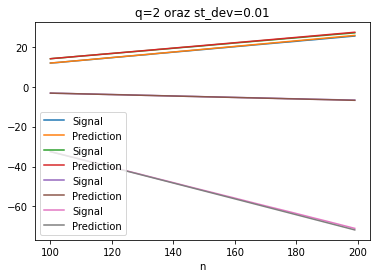



Dla q=2 oraz st_dev=1
MSE: 22.104786682549616


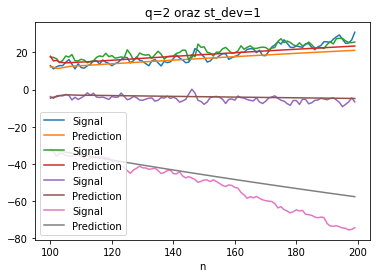



Dla q=2 oraz st_dev=10
MSE: 562.9738786439158


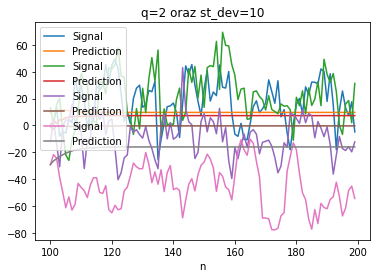



Dla q=10 oraz st_dev=0.01
MSE: 0.005320474145211108


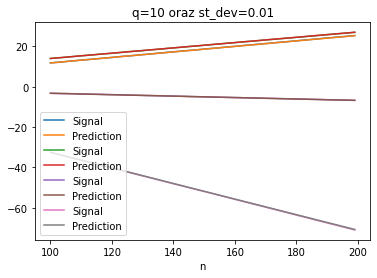



Dla q=10 oraz st_dev=1
MSE: 45.3943526057842


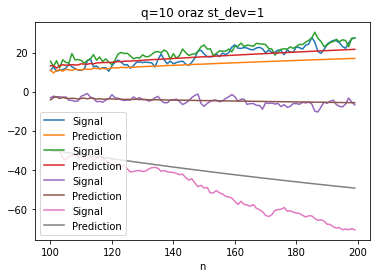



Dla q=10 oraz st_dev=10
MSE: 1111.4853060309956


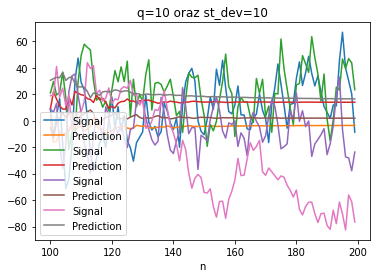



Dla q=15 oraz st_dev=0.01
MSE: 0.011701231447321438


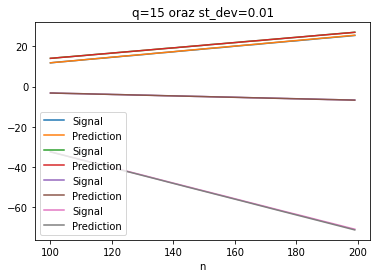



Dla q=15 oraz st_dev=1
MSE: 21.864091573609656


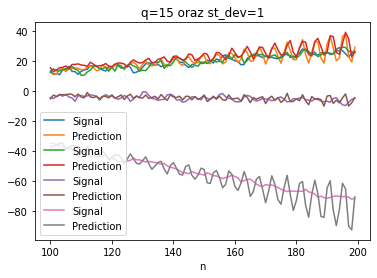



Dla q=15 oraz st_dev=10
MSE: 1728.5831422349852


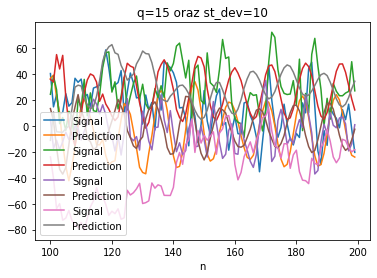

In [10]:
from sklearn.metrics import mean_squared_error

for q in q_values:
    for st_dev in st_dev_values:
        S = np.zeros((n*2, 4))
        S[:2] = np.random.normal(0, st_dev, (2, 4))  # mean and standard deviation
        for i in range(2, len(S)):
            S[i] = A1@S[i-1] + A2@S[i-2] + B*i + sigma@np.random.normal(0.01, st_dev, 4)
        VAR_model = vr.VAR(S[:n])
        model_fitted = VAR_model.fit(q)
        results = model_fitted.forecast(y=S[:n], steps=n)
        print(f'Dla q={q} oraz st_dev={st_dev}')
        print(f'MSE: {mean_squared_error(S[n:], results)}')
        for signal, res in zip(S[n:].T, results.T):
            plt.title(f'q={q} oraz st_dev={st_dev}')
            plt.xlabel('n')
            plt.plot(np.arange(n, n*2), signal, label='Signal')
            plt.plot(np.arange(n, n*2), res, label='Prediction')
        plt.legend()
        plt.show()
        print('\n')

## Wnisoki
Wraz ze wzorstem liczby q, która mówi ile wcześniejszych przebiegów branych jest pod uwagę do predykcji, wartości przewidywane są bardziej dopasowana do danych uczących. W przeprowadzonym eksperymencie do pewnych wartości wariancji zmniejszyło to średni błąd kwadratowy (MSE). Odbywa się to kosztem generalizacji i podowuje przeuczony model. 